<a href="https://colab.research.google.com/github/sungulnara2000/DocumentDistortion/blob/main/Text_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Настройка среды

In [ ]:
!git config --global user.email "sungulnara2000@gmail.com"
!git config --global user.name "Gulnara Sungatullina"

In [ ]:
!git add src/distortion.py

In [ ]:
!git commit -m "find paper contour after transformation, not from photo"

[master d6e612c] find paper contour after transformation, not from photo
 2 files changed, 20 insertions(+), 39 deletions(-)


In [ ]:
!git pull

error: You have not concluded your merge (MERGE_HEAD exists).
hint: Please, commit your changes before merging.
fatal: Exiting because of unfinished merge.


In [ ]:
!git push

Counting objects: 5, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 809 bytes | 404.00 KiB/s, done.
Total 5 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/sungulnara2000/CrumpledDocumentsDataset.git
   04d7f67..d6e612c  master -> master


In [ ]:
!pip install -U opencv-contrib-python==4.3.0.36 # inpainting
# !pip install opencv-contrib-python==3.4.2.17 # SURF
!pip install -U plotly==4.12
!pip install pyheif Pillow
!apt-get install poppler-utils
!pip install alphashape
!pip install PyPDF2
!pip install pdfminer
!pip install pdf2image

In [3]:
import os
import glob
from multiprocessing import Pool
from zipfile import ZipFile
from tqdm import tqdm

import cv2 as cv
from google.colab.patches import cv2_imshow

In [ ]:
%ls

sample_data/


In [ ]:
!ls

dataset  dataset_small_new.zip	sample_data


In [ ]:
len(os.listdir('dataset/crumpled_ground_truths'))

2723

In [ ]:
len(os.listdir('dataset/crumpled_docs'))

1880

# Experiments

In [ ]:
!pip install pytorch_lightning

In [2]:
import os
import time
import glob
import requests
from tqdm.notebook import tqdm
from collections import defaultdict
import random
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import albumentations as A

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

from sklearn.metrics import f1_score

import torchvision
from torchvision import datasets, transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2, style='whitegrid')

# device_num = 0
# torch.cuda.set_device(device_num)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import torch
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F

from PIL import Image
from torch.utils.data import Dataset, random_split

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
%cd /content/

/content


In [4]:
!cp /content/drive/MyDrive/document_distortion/paper_distortions/dataset_small_new.zip .

In [ ]:
!unzip -n /content/dataset_small_new.zip

In [6]:
without_gt = set(os.listdir('dataset/crumpled_docs')) - set(os.listdir('dataset/crumpled_ground_truths'))
len(without_gt)

0

In [7]:
files = set(os.listdir('dataset/crumpled_ground_truths')) & set(os.listdir('dataset/crumpled_docs'))
len(files)

1880

In [5]:
# Путь до папки с данными
DATA_PATH = "dataset"

In [9]:
img_name = list(files)[0]

img_path = os.path.join(DATA_PATH, "crumpled_docs", img_name)
mask_path = os.path.join(DATA_PATH, "crumpled_ground_truths", img_name)

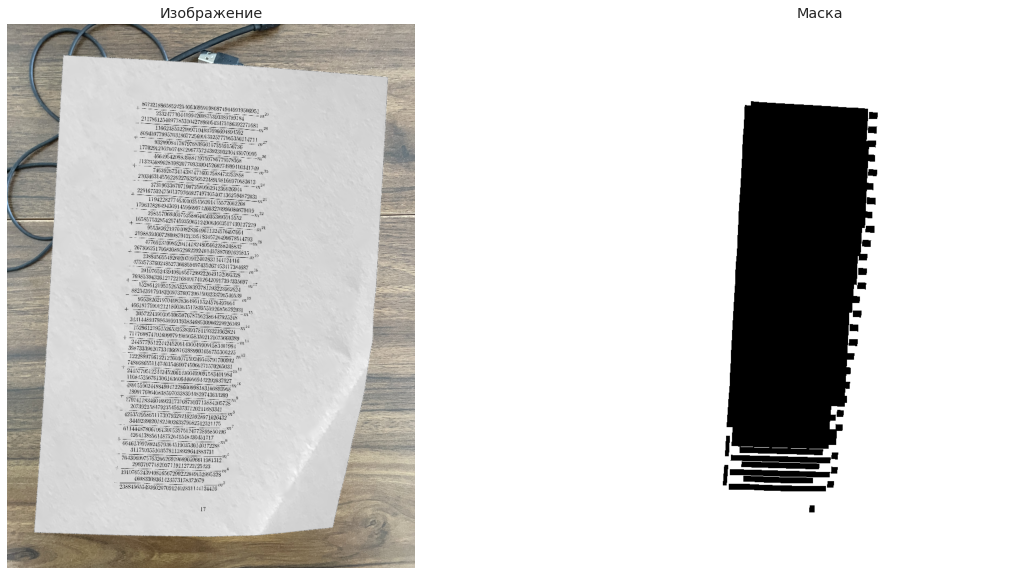

In [13]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title("Изображение")
plt.imshow(Image.open(img_path))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(Image.open(mask_path))
plt.axis("off");

In [6]:
class CrumpledDocsDataset(Dataset):
    """ 
    Carvana features dataset.  
    Override torch Dataset class to implements reading from h5 files
    """

    def __init__(self, data_path, mask_path, input_size=(1008, 752)):
        """
        Args:
            data_path: путь до изображений.
            mask_path: путь до масок изображений.
        """
        self.data_path = data_path
        self.mask_path = mask_path

        # Файлы с изображениями и масками
        self.files = set(os.listdir(data_path)) & set(os.listdir(self.mask_path)) 
        self.files = list(self.files)[:1500]

        geom_transforms = transforms.Compose([                                
            transforms.Resize(input_size),
            transforms.ToTensor(),
        ])

        color_transforms = transforms.Compose([                                
            transforms.ColorJitter(brightness=0.2, contrast=0.2, hue=0.5),
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
        ])

        # Преобразование для изображений
        self.transform = transforms.Compose([                                
            geom_transforms,
            color_transforms,
        ])
        # Преобразование для масок
        self.transform_mask = transforms.Compose([
            geom_transforms,
            transforms.Grayscale()
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Загружаем изображение и маску
        file_name = os.path.join(self.data_path, self.files[idx])
        mask_name = os.path.join(self.mask_path, self.files[idx])

        # Пробразуем изображение и маску
        input = self.transform(Image.open(file_name))
        target = self.transform_mask(Image.open(mask_name))

        if random.random() > 0.7:
          input = transforms.functional.invert(input)
        #   input = transforms.functional.vflip(input)
        #   target = transforms.functional.vflip(target)

        # Приводим таргет/маску к такому виду, 
        # чтобы его значения были от 0 до 1
        target = (target > 0).long()

        return input, target

In [7]:
# Датасет с данными для обучения и вадидации
dataset = CrumpledDocsDataset(os.path.join(DATA_PATH, "crumpled_docs"), 
                         os.path.join(DATA_PATH, "crumpled_ground_truths"))

# Разделение на обучающую и валидационную части
val_ratio = 0.2
data_len = len(dataset)
val_len = int(data_len * val_ratio)
train_len = data_len - val_len
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(
    dataset, lengths=(train_len, val_len), generator=generator)

Значения в маске и количество значений: (array([0, 1]), array([369028, 388988]))


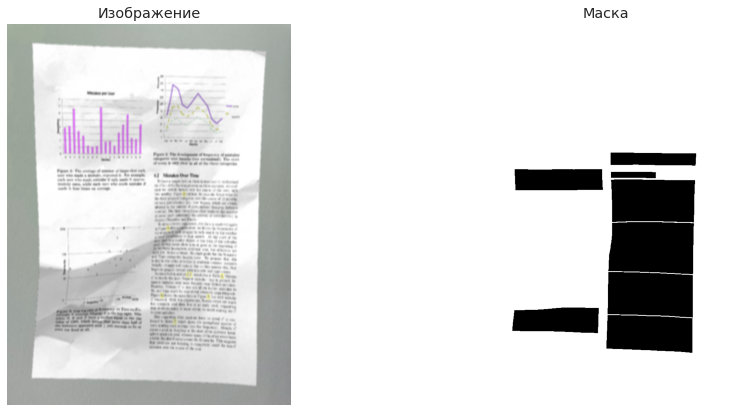

In [121]:
i = 5

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.title("Изображение")

plt.imshow(train_dataset[i][0].permute(1, 2, 0))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(train_dataset[i][1].squeeze(), cmap='Greys_r')
plt.axis("off");

print("Значения в маске и количество значений:", np.unique(dataset[i][1], return_counts=True))

In [8]:
def iou(predicted_mask_batch, target_mask_batch):
    """ Считает IoU для всех элементов батча """
    
    iou = np.logical_and(predicted_mask_batch, target_mask_batch).sum(axis=(1, 2)) / np.logical_or(predicted_mask_batch, target_mask_batch).sum(axis=(1, 2))
    return iou

In [9]:
class ConvSeq(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(2, 3), padding='same'), # padding=1 ?
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(2, 3), padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.seq(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.seq = nn.Sequential(nn.MaxPool2d(2), ConvSeq(in_channels, out_channels))
        
    def forward(self, x):
        return self.seq(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvSeq(in_channels, out_channels)

    def forward(self, x, copy):
        x = self.up(x)
        concat = torch.cat([copy, x], dim=1)
        out = self.conv(concat)
        return out

In [10]:
class MyUnet(nn.Module):
    def __init__(self):
        super(MyUnet, self).__init__()

        self.start = ConvSeq(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.finish = nn.Conv2d(64, 2, 1)

    def forward(self, input):
        layer1 = self.start(input)
        layer2 = self.down1(layer1)
        layer3 = self.down2(layer2)
        layer4 = self.down3(layer3)
        layer5 = self.down4(layer4)
        layer6 = self.up1(layer5, layer4)
        layer7 = self.up2(layer6, layer3)
        layer8 = self.up3(layer7, layer2)
        layer9 = self.up4(layer8, layer1)
        out = self.finish(layer9)
        return out

In [11]:
def plot_learning_curves(history):
    '''
    Функция для вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    # sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('точность', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [12]:
batch_size = 2

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [31]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=50,
    save_path=None,
    patience=5
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :param save_path: путь, куда сохранять модель

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    # early_stopping = EarlyStopping(patience=patience, verbose=True)

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in tqdm(train_batch_gen):
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты на выходе модели
            logits = model(X_batch)
            
            # Подсчитываем лосс
            loss = criterion(logits, y_batch.squeeze(1).to(device))

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()
            
            # Сохраяняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += iou(y_batch.cpu().numpy().squeeze(1), y_pred).mean()

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # Полный проход по валидации    
        
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты, полученные моделью
            with torch.no_grad():
              logits = model(X_batch)

            # Лосс на валидации
            loss = criterion(logits, y_batch.squeeze(1).to(device))

            # Сохраяняем лоссы и точность на валидации
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += iou(y_batch.cpu().numpy().squeeze(1), y_pred).mean()
            

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)

        if save_path is not None:
          torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'history': dict(history),
          }, save_path)
      
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        # early_stopping(val_loss, model)
        
        # if early_stopping.early_stop:
        #     print("Early stopping")
        #     break
        
    return model, history

In [15]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)

cuda


In [16]:
load_data = torch.load('drive/MyDrive/document_distortion/models/unet/more_data.pt')

In [28]:
model = MyUnet()
model.load_state_dict(load_data['model_state_dict'])

model = model.to(device)

In [129]:
# model = MyUnet()
# model = model.to(device)

In [18]:
load_data.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'history'])

In [25]:
load_data['history']

9

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [131]:
import torch
torch.cuda.empty_cache()

In [132]:
!nvidia-smi

Wed Jun 22 13:44:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    33W /  70W |   2462MiB / 15109MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [133]:
# !touch drive/MyDrive/document_distortion/models/unet/more_data_1500.pt

In [ ]:
model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=5,
    save_path='drive/MyDrive/document_distortion/models/unet/more_data_1500.pt'
)

  0%|          | 0/600 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:444: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  self.padding, self.dilation, self.groups)


Epoch 10 of 10 took 1519.963s
  training loss (in-iteration): 	0.196865
  validation loss (in-iteration): 	0.228347
  training accuracy: 			90.84 %
  validation accuracy: 			90.08 %


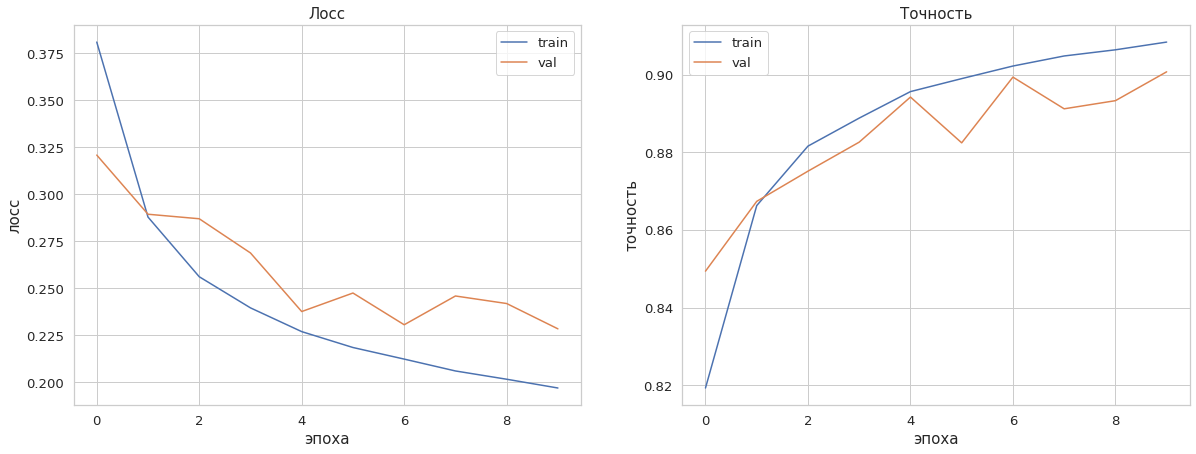

In [134]:
# model, history = train(
#     model, criterion, optimizer, 
#     train_batch_gen, val_batch_gen, 
#     num_epochs=10,
#     save_path='drive/MyDrive/document_distortion/models/unet/more_data.pt'
# )

In [19]:
!ls dataset/crumpled_docs | head

IMG_3249$A Brief Introduction to the Standard Annotation Language (SAL) - 2006_dpi_400_0001-5$aug$a4172a23-9c6e-486e-88c6-166d55ad7ffb.png
IMG_3249$A Brief Tutorial on Database Queries, Data Mining, and OLAP (hamel-197-manuscript-final)_dpi_400_0001-02.png
IMG_3249$A Comparison of Software and Hardware Techniques for x86 Virtualization - Oct 2015 (asplos235_adams)_dpi_400_0001-04.png
IMG_3249$A Compressed Suffix Tree Based Implementation with Low Peak Memory Usage (2014)_dpi_400_0001-02$aug$553c1cd7-c9dd-42b9-983d-e38d79904107.png
IMG_3249$A Course in Machine Learning (ciml-v0_9-all)_dpi_400_0001-005.png
IMG_3249$A Crash Course in x86 Assembly for Reverse Engineers - SensePost (2014)_dpi_400_0001-01$aug$b6948339-b1ab-40c8-8399-c95a71cac737.png
IMG_3249$A Family of Perfect Hashing Methods - 1996 (TR0242)_dpi_400_0001-02$aug$85dd235a-3197-4299-bf6e-7b56b6b803e4.png
IMG_3249$A Few Experiments with Intel's Cache Allocation Technology - Slides (2015)_dpi_400_0001-03$aug$6ec42fd9-aa2b-4691-9

In [39]:
test_i = 1600
test_file = glob.glob('dataset/crumpled_docs/*')[test_i]
mask_file = f'dataset/crumpled_ground_truths/{os.path.basename(test_file)}'

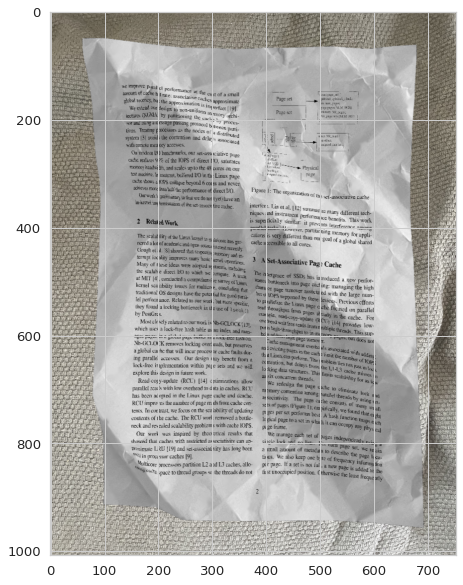

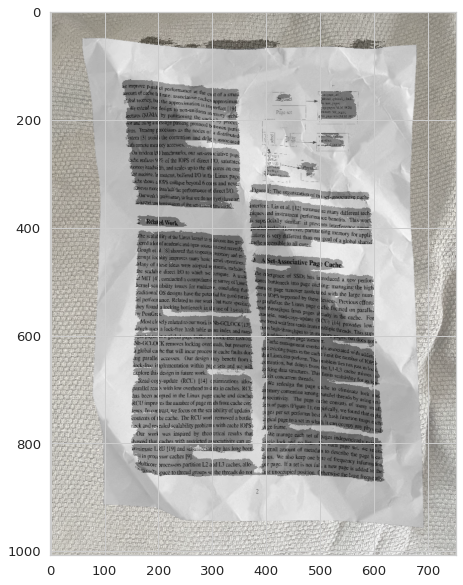

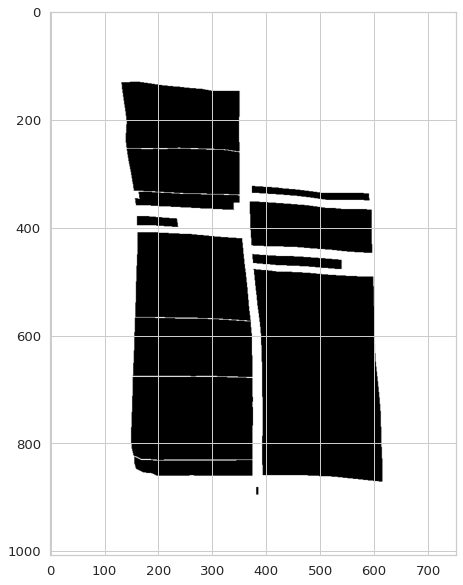

In [44]:
input_size=(1008, 752)
transform = transforms.Compose([                                
            transforms.Resize(input_size),
            transforms.ToTensor(),
        ])

input = transform(Image.open(test_file))
input = input.reshape((1, 3, 1008, 752)).to(device)

with torch.no_grad():
  logits = model(input)
y_pred = logits.max(1)[1].detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(input.cpu().squeeze().permute(1, 2, 0))
plt.axis("off");

plt.figure(figsize=(10, 10))
plt.imshow(input.cpu().squeeze().permute(1, 2, 0))
plt.imshow(y_pred.squeeze(), cmap='Greys_r', alpha=0.3)
plt.axis("off");

mask = transform(Image.open(mask_file))
plt.figure(figsize=(10, 10))
plt.imshow(mask.permute(1, 2, 0))
plt.axis("off");

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:444: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  self.padding, self.dilation, self.groups)


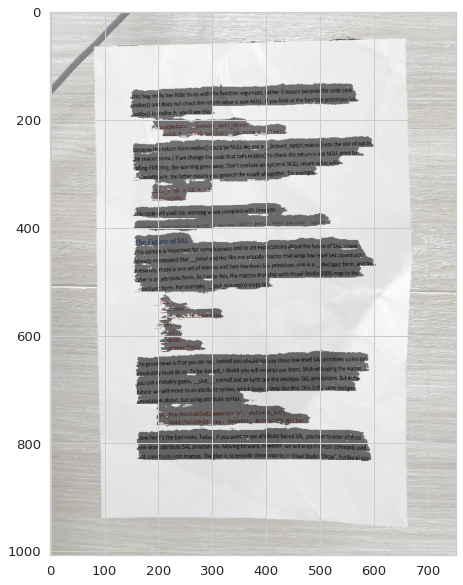

In [22]:
input_size=(1008, 752)
transform = transforms.Compose([                                
            transforms.Resize(input_size),
            transforms.ToTensor(),
        ])

input = transform(Image.open('dataset/crumpled_docs/IMG_3249$A Brief Introduction to the Standard Annotation Language (SAL) - 2006_dpi_400_0001-5$aug$a4172a23-9c6e-486e-88c6-166d55ad7ffb.png'))
input = input.reshape((1, 3, 1008, 752)).to(device)

with torch.no_grad():
  logits = model(input)
y_pred = logits.max(1)[1].detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(input.cpu().squeeze().permute(1, 2, 0))
plt.imshow(y_pred.squeeze(), cmap='Greys_r', alpha=0.5)

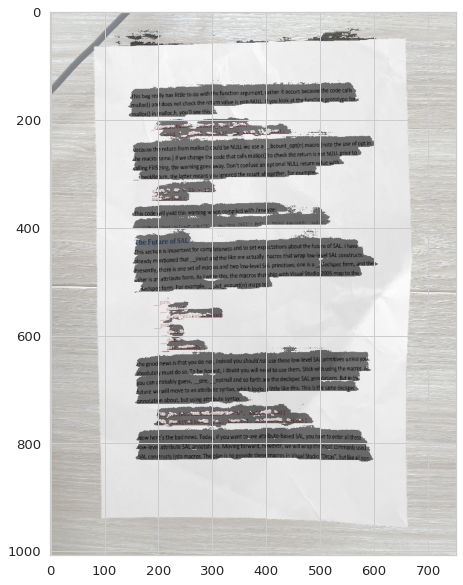

In [118]:
input_size=(1008, 752)
transform = transforms.Compose([                                
            transforms.Resize(input_size),
            transforms.ToTensor(),
        ])

input = transform(Image.open('dataset/crumpled_docs/IMG_3249$A Brief Introduction to the Standard Annotation Language (SAL) - 2006_dpi_400_0001-5$aug$a4172a23-9c6e-486e-88c6-166d55ad7ffb.png'))
input = input.reshape((1, 3, 1008, 752)).to(device)

with torch.no_grad():
  logits = model(input)
y_pred = logits.max(1)[1].detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(input.cpu().squeeze().permute(1, 2, 0))
plt.imshow(y_pred.squeeze(), cmap='Greys_r', alpha=0.5)